In [2]:
import os
#move up in directory
os.chdir('../')
#os.getcwd()

In [3]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD\\p1_generalization'

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from sklearn.metrics import mean_squared_error

from helpers import dot2_

# RNN agents

In [5]:
num_ins = 30
n_walks = 3

isi = np.array([])

for id_ in range(num_ins):
    for walk in range(1, n_walks+1):
        
        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df = d.reset_index()
        
        is_switch =  df['is_switch'].to_numpy()
        switch_indices = np.where(is_switch==1)[0]
        isi = np.append(isi, switch_indices[1:] - switch_indices[:-1])


In [6]:
rnn_isi = isi

# Human agents

In [7]:
path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)
isi = np.array([])


In [8]:
for sub in range(1,31):
    temp_df = human_df[human_df['vp'].values==sub]
    ch = temp_df.choice.to_numpy()
    is_switch = np.array([int(ch[t] != ch[t-1]) for t in range(1, len(ch))])
    switch_indices = np.where(is_switch==1)[0]
    isi = np.append(isi, switch_indices[1:] - switch_indices[:-1])




In [9]:
human_isi = isi

# Mixture Fitting

In [10]:
def discrete_exp_mix(x, K=2, plot_it=True, verbose=True):
    # Function to fit a mixture of discrete exponential distributions to inter-event intervals
    
    if np.min(x) == 0:
        x = x - 1
        subtracted = True
    else:
        subtracted = False
    
    epsilon = 1e-6
    max_iter = 1e4
    
    # Initialize parameters
    betas = np.full((K,), np.nan)
    weights = np.full((K,), np.nan)
    t_hat = np.full((K * 2,), np.nan)
    
    # Find starting values by splitting up the data
    bins = np.linspace(np.min(x), np.max(x), K + 1)
    for k in range(K):
        betas[k] = np.nanmean(x[(x >= bins[k]) & (x <= bins[k + 1])])
        weights[k] = 1 / K  # start by assuming an equal mixture
    
    # Fill into the parameter vector
    t_hat[0::2] = betas
    t_hat[1::2] = weights
    
    # Define geometric pdf
    def geo_f(x, beta):
        return (1 / (1 + beta)) * ((beta / (1 + beta)) ** x)
    
    # Define weighted distributions formula
    def w_f(x, theta):
        return theta[1] * geo_f(x, theta[0])
    
    def z_labels(x, theta):
        # Generate the Z labels for this iteration
        K = len(theta) // 2
        Z = np.full((K, len(x)), np.nan)
        idx = np.array([0, 1])

        for k in range(K):
            Z[k, :] = w_f(x, theta[idx])
            idx = idx + 2
        
        pdf = np.copy(Z)
        G = np.sum(Z, axis=0)
        G = G + 5e-324 # avoid divide by 0's
        Z = Z / G

        return Z, pdf
    
    if K != 1:
        print('Starting EM')
        exit_flag = True  # switches to false if we exit for a bad reason
        i = 0
        stop = False
        while not stop:
            # E-step: calculate the expectation of our observations | params
            Z, pdf = z_labels(x, t_hat)
            
            # M-step: update the parameters
            betas = t_hat[0::2]
            weights = t_hat[1::2]
            betas_n = np.full_like(betas, np.nan)
            weights_n = np.full_like(weights, np.nan)
            
            # Update the betas
            for k in range(K):
                betas_n[k] = np.sum(Z[k, :] * x) / np.sum(Z[k, :])
            
            # Update the weights
            weights_n = np.mean(Z, axis=1)
            
            # CHECK HERE that with weights
            #pdb.set_trace()
            
            # Update theta estimates for the next round
            last_t_hat = np.copy(t_hat)
            t_hat[0::2] = betas_n
            t_hat[1::2] = weights_n
            
            # Stop if we've reached our stopping criteria
            stop = np.all(np.logical_and(1 - epsilon <= t_hat / last_t_hat, t_hat / last_t_hat <= 1 + epsilon))
            stop = stop or i > max_iter
            
            if np.sum(np.isnan(t_hat)) > 0:
                stop = True
                exit_flag = False
            
            if verbose and round(i / 100) * 100 == i:
                lik = np.sum(np.log(np.sum(pdf, axis=0)))
                print(f'\n Iter: {i}, Likelihood: {lik:.4f}')
            
            i += 1
    else:
        # If K == 1, ML estimate is the mean of observations
        t_hat[0] = np.mean(x)
        t_hat[1] = 1
        exit_flag = True
        i = 0
    
    if exit_flag:
        print(f'\n EM finished after {i} iterations')
        
        theta = t_hat
        
        # Get max likelihood mixture
        Z, pdf = z_labels(x, theta)
        Z_labels = np.argmax(Z, axis=0)
        
        # Likelihood
        lik = np.sum(np.log(np.sum(pdf, axis=0)))
        
        if plot_it:

            for beta in theta[0::2]:
                plt.plot(np.arange(1, np.max(x)+1), geo_f(np.arange(1, np.max(x)+1), beta), linewidth=1, c = 'black', linestyle='dashed')

            _, pdf_plot = z_labels(np.arange(1, np.max(x)+1), theta)
            plt.plot(np.arange(1, np.max(x)+1), np.sum(pdf_plot, axis=0), linewidth=2, c = 'black')
            _= plt.hist(x, weights = np.ones(len(x)) / len(x), bins = int(np.max(x)), color = 'grey')
            
            plt.show()
        
        # If we subtracted 1 to make the data start at 0 to fit the model,
        # we need to correct the survival parameter for interpretability
        if subtracted:
            theta[0::2] = theta[0::2] + 1
        
        return theta, Z_labels, lik
    else:
        print('\n EM failed to converge!')
        return None
    
# Example usage:
# theta, Z_labels, lik = discrete_exp_mix(x, K=2)


# RNN Mixture fitting

Starting EM

 Iter: 0, Likelihood: -12508.9404

 EM finished after 40 iterations


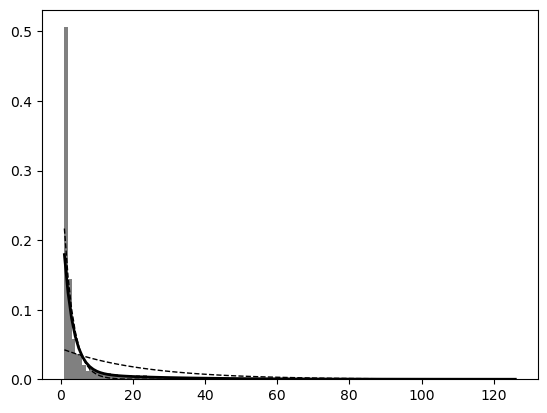

In [11]:
theta, Z_labels, lik = discrete_exp_mix(rnn_isi, K=2, plot_it=True, verbose=True)

In [12]:
theta

array([ 2.14955188,  0.78510556, 21.55167893,  0.21489444])

In [13]:
lik = np.zeros(4)

for k in range(1,5):
    _,_, lik[k-1] = discrete_exp_mix(rnn_isi, K=k, plot_it=False, verbose=True)


 EM finished after 0 iterations
Starting EM

 Iter: 0, Likelihood: -12508.9404

 EM finished after 40 iterations
Starting EM

 Iter: 0, Likelihood: -13119.6242

 Iter: 100, Likelihood: -10650.6609

 EM finished after 111 iterations
Starting EM

 Iter: 0, Likelihood: -13576.5442

 Iter: 100, Likelihood: -10650.6609

 EM finished after 124 iterations


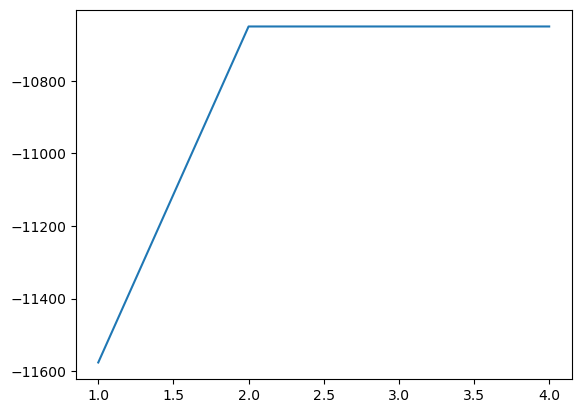

In [17]:
plt.plot(range(1,5), lik)

Starting EM

 Iter: 0, Likelihood: -7356.0203

 EM finished after 76 iterations


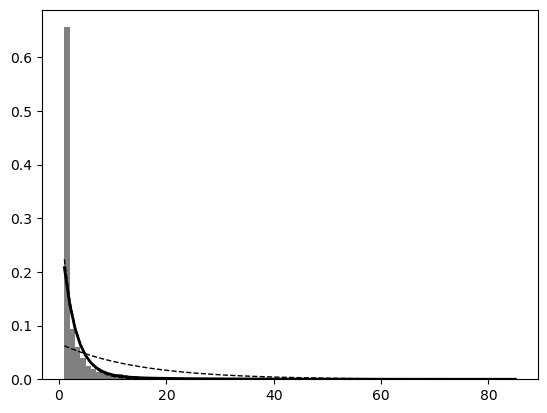

In [18]:
# Human
theta, Z_labels, lik = discrete_exp_mix(human_isi, K=2, plot_it=True, verbose=True)

In [19]:
thetaa

NameError: name 'thetaa' is not defined

In [103]:
lik = np.zeros(4)

for k in range(1,5):
    _,_, lik[k-1] = discrete_exp_mix(human_isi, K=k, plot_it=False, verbose=True)


 EM finished after 0 iterations
Starting EM

 Iter: 0, Likelihood: -7356.0203

 EM finished after 76 iterations
Starting EM

 Iter: 0, Likelihood: -8011.6809

 Iter: 100, Likelihood: -6102.3061

 Iter: 200, Likelihood: -6102.1035

 Iter: 300, Likelihood: -6102.1035

 EM finished after 317 iterations
Starting EM

 Iter: 0, Likelihood: -8345.0356

 Iter: 100, Likelihood: -6102.1049

 Iter: 200, Likelihood: -6102.1035

 EM finished after 248 iterations


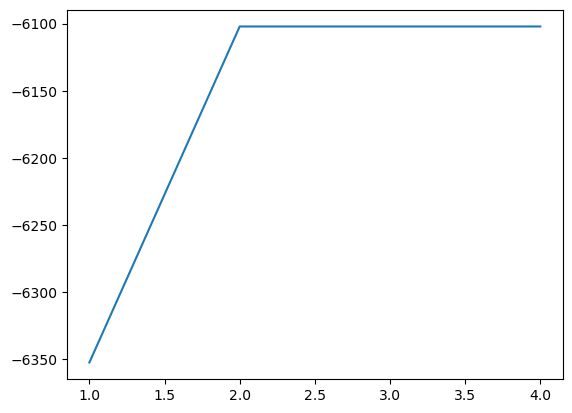

In [105]:
plt.plot(range(1,5), lik)